# Classifying imdb reviews as negative or positive using LSTM neural network model

### **1. Loading the data**

In [3]:
from tensorflow.keras import datasets

imdb = datasets.imdb

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# create train and test data using the load_data method
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

17473536/17464789 [==============================] - 0s 0us/step


***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [4]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [5]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, we will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

In [6]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGTH = 500

padded_train_data = pad_sequences(train_data, padding = 'pre', value = 0, maxlen = MAX_LENGTH)
padded_test_data = pad_sequences(test_data, padding = 'pre', value = 0, maxlen = MAX_LENGTH)

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process. 

In [7]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, we will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. 
*  The third step is to add an LSTM with 100 units. 
*  The final layer of the model is a fully connected (Dense) layer. We use the sigmoid as the activation function.
*  We compile the model with a 'binary_crossentropy' loss function, an 'adam' optimizer.

In [8]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model

EMBED_SIZE = 100
# Input layer]
target_input = Input((500,), dtype='int32')


# Embedding llayer
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                          mask_zero= True,
                         	input_length=500)(target_input)
                          
# lstm layer
target_lstm = LSTM(100)(target_embedding)

# output layer
label = Dense(1, activation = 'sigmoid')(target_lstm)

model = Model(inputs=[target_input], outputs=[label])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 500, 100)         1000000   
 ng)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


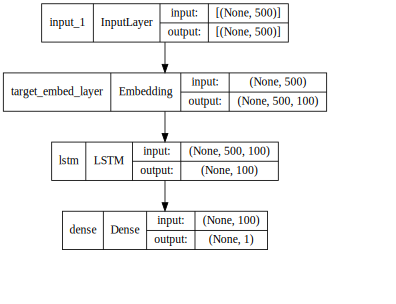

In [10]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**




**Step 1: Getting a validation dataset**

Before we begin training, we will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [11]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [12]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 29s 1s/step - loss: 0.6591 - accuracy: 0.6268 - val_loss: 0.6222 - val_accuracy: 0.6180
Epoch 2/6
23/23 [==============================] - 22s 953ms/step - loss: 0.5512 - accuracy: 0.7121 - val_loss: 0.6241 - val_accuracy: 0.6355
Epoch 3/6
23/23 [==============================] - 24s 1s/step - loss: 0.6012 - accuracy: 0.6857 - val_loss: 0.5982 - val_accuracy: 0.6990
Epoch 4/6
23/23 [==============================] - 22s 956ms/step - loss: 0.5458 - accuracy: 0.7561 - val_loss: 0.5392 - val_accuracy: 0.7310
Epoch 5/6
23/23 [==============================] - 22s 949ms/step - loss: 0.4158 - accuracy: 0.8243 - val_loss: 0.3802 - val_accuracy: 0.8410
Epoch 6/6
23/23 [==============================] - 22s 947ms/step - loss: 0.2784 - accuracy: 0.8858 - val_loss: 0.3278 - val_accuracy: 0.8670


**Step 3: Visualize the model plot**

In [13]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=b4c23639e7608905ec22b2d33aaa7173ecffde59da16d5b77334ae9626508af0
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=cc13866e3de975f4f1d81fff63747c8f0d7b155912ab1c2735e68f599b589b9c
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=f10ba3e7984e1fe010e1daf2d9af9188a62f3da43080556d049c027f23a517e1
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [14]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

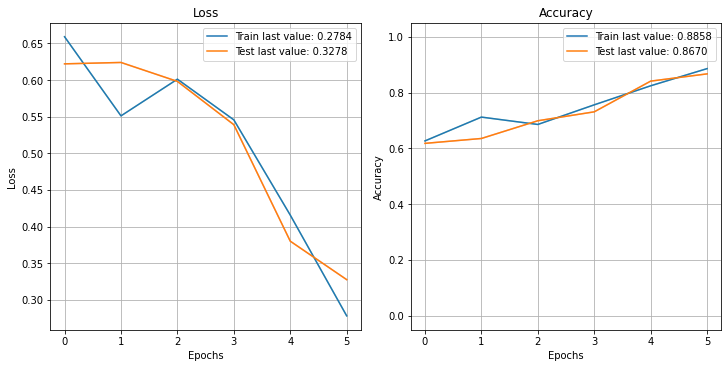

In [15]:
plot_history(history.history, path="standard.png")
plt.show()

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### **5. Evaluating the Model on the Test Data**

In [17]:
results = model.predict(padded_test_data)
print('test_loss:', results[0], 'test_accuracy:', results[1])

test_loss: [0.29540563] test_accuracy: [0.9833319]


###**6. Extracting the Word Embeddings**

We extract the word embeddings from the embedding layer model


In [18]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0]

***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [19]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary:

In [20]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1654784/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [21]:
word2idx.items()

dict_items([('woods', 1410), ('hanging', 2347), ('woody', 2291), ('arranged', 6748), ('bringing', 2340), ('wooden', 1638), ('errors', 4012), ('dialogs', 3232), ('kids', 361), ('uplifting', 5036), ('controversy', 7095), ('projection', 9880), ('stern', 7182), ('morally', 5623), ('wang', 5285), ('want', 180), ('travel', 2105), ('barbra', 6704), ('dinosaurs', 3932), ('wrong', 354), ('subplots', 4762), ('welcomed', 9094), ('butcher', 6705), ('fit', 1182), ('screaming', 1929), ('fix', 4289), ('hurting', 9656), ('effects', 301), ('barton', 8777), ('ingrid', 6194), ('adapt', 7918), ('disturbed', 4013), ('purpose', 1287), ('olds', 6794), ('needed', 886), ('master', 1299), ('positively', 5401), ('zatoichi', 9838), ('feeling', 546), ('affairs', 5624), ('wholesome', 7801), ('cinematic', 1359), ('tech', 4990), ('saying', 659), ('padded', 8424), ('tempted', 5747), ('plate', 7478), ('altogether', 3901), ('lds', 8778), ('nicely', 1779), ('mummy', 4590), ('lots', 774), ('lotr', 9261), ('irs', 9881), ('

In [22]:
idx2word = {v:k for k,v in word2idx.items()}
idx2word.items()

dict_items([(1410, 'woods'), (2347, 'hanging'), (2291, 'woody'), (6748, 'arranged'), (2340, 'bringing'), (1638, 'wooden'), (4012, 'errors'), (3232, 'dialogs'), (361, 'kids'), (5036, 'uplifting'), (7095, 'controversy'), (9880, 'projection'), (7182, 'stern'), (5623, 'morally'), (5285, 'wang'), (180, 'want'), (2105, 'travel'), (6704, 'barbra'), (3932, 'dinosaurs'), (354, 'wrong'), (4762, 'subplots'), (9094, 'welcomed'), (6705, 'butcher'), (1182, 'fit'), (1929, 'screaming'), (4289, 'fix'), (9656, 'hurting'), (301, 'effects'), (8777, 'barton'), (6194, 'ingrid'), (7918, 'adapt'), (4013, 'disturbed'), (1287, 'purpose'), (6794, 'olds'), (886, 'needed'), (1299, 'master'), (5401, 'positively'), (9838, 'zatoichi'), (546, 'feeling'), (5624, 'affairs'), (7801, 'wholesome'), (1359, 'cinematic'), (4990, 'tech'), (659, 'saying'), (8424, 'padded'), (5747, 'tempted'), (7478, 'plate'), (3901, 'altogether'), (8778, 'lds'), (1779, 'nicely'), (4590, 'mummy'), (774, 'lots'), (9261, 'lotr'), (9881, 'irs'), (6


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [23]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

We visualize the word embeddings for 10 of the words using pandas DataFrame

In [24]:
word_embeddings[3]

array([ 0.00985725, -0.00115578,  0.01802174,  0.01154937, -0.02087186,
       -0.00710282, -0.00770044,  0.01098756, -0.00053616,  0.01121446,
       -0.00983966,  0.01007698,  0.00185264,  0.02175834,  0.0086679 ,
       -0.01888958, -0.0188967 , -0.02139463,  0.014673  ,  0.02060788,
        0.0017802 , -0.01316303,  0.01669643, -0.02121488,  0.02114423,
       -0.01499253, -0.01409662,  0.01074062,  0.02331153, -0.00146513,
       -0.00437431, -0.00458278,  0.00217145,  0.00653858,  0.01702319,
        0.00765504,  0.01794888, -0.01384328,  0.01284565,  0.01208202,
        0.01731829,  0.00679662, -0.01197222,  0.00079655,  0.00700177,
       -0.01250795,  0.00346821,  0.01566365,  0.01882238, -0.02170914,
        0.02106328, -0.01791458,  0.01162663, -0.00541137, -0.02122244,
       -0.01491858, -0.01242913,  0.01475807,  0.01868627,  0.021091  ,
        0.0217872 ,  0.00183651,  0.01823844,  0.03175041,  0.00947967,
       -0.00105409,  0.01628517, -0.00934559, -0.01215357, -0.02

In [25]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2   ...        97        98        99
woods      0.004144  0.004803  0.011505  ...  0.020947 -0.002356 -0.013930
hanging   -0.005587 -0.011078 -0.012600  ...  0.005334  0.019942 -0.002222
woody     -0.011981 -0.035338 -0.009297  ... -0.006578  0.014545 -0.016022
arranged   0.009857 -0.001156  0.018022  ... -0.016012  0.001158 -0.012507
bringing  -0.033751  0.038188  0.007761  ... -0.015548 -0.000146  0.026358
wooden     0.016067 -0.006804 -0.006994  ...  0.001048  0.021872 -0.018476
errors     0.027584  0.016133 -0.014700  ...  0.016225 -0.007285  0.011418
dialogs    0.034325 -0.011734  0.027308  ...  0.016091 -0.032037 -0.034797
kids      -0.014122  0.001829 -0.017045  ... -0.013137  0.014402  0.019365
uplifting  0.008691 -0.017922 -0.012140  ...  0.008588  0.003506  0.006702

[10 rows x 100 columns]


###**9. Plot Word Embeddings using t-SNE**


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


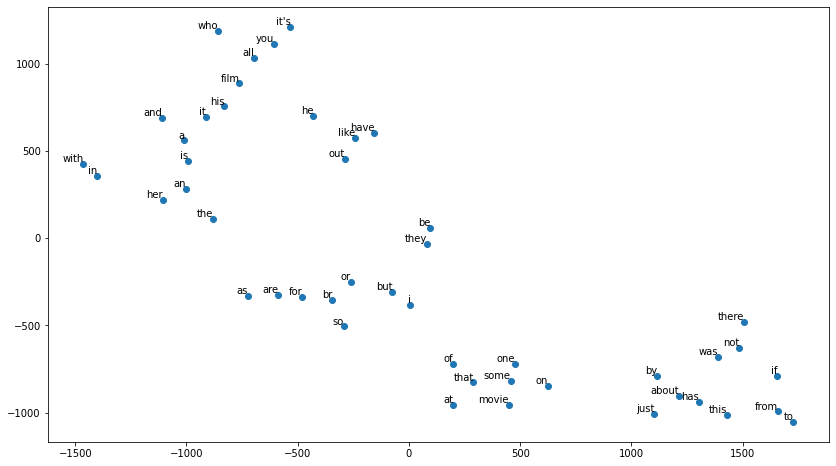

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 #we will only plot for 50 words

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        
